In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

In [3]:
tf.random.set_seed(12345)
np.random.seed(5678)
random.seed(123)

# Get Data

In [4]:
split_test_data = pd.read_csv('../Data/SplitWord2VecDataV2.csv')

In [5]:
x_train, x_test, y_train, y_test = train_test_split(split_test_data['text'], split_test_data['marked'], stratify=split_test_data['marked'], random_state=12345)

In [6]:
x_train

24562     51: 29 and the land shall tremble and sorrow: ...
120983                               she did not hands him.
5000      could a linguist, could a grammarian, could ev...
124015                                 solid, settled lost.
124413    bobby joe was trying to get linda kay to say s...
                                ...                        
47756       " it is a new planet and it shall bear my name.
99588     mandatory retirement at sixty-five looms on ou...
78109        fellow, come from the throng, look vpon caesar
111535    the uniform fiscal year brings the town's fisc...
96866                             check put of lid on jar;;
Name: text, Length: 103978, dtype: object

In [7]:
y_train

24562     0
120983    1
5000      0
124015    0
124413    1
         ..
47756     0
99588     1
78109     0
111535    0
96866     1
Name: marked, Length: 103978, dtype: int64

In [8]:
x_test

129828                     gradually they emerged as women.
40550     17: 20 and when absalom' s servant came to the...
75649     and now that at the proper time and place, aft...
130984                     "you're not to mentions my name.
70670     here you are, pip; and there' s the windlass -...
                                ...                        
78390     harke, harke, one knockes: portia go in a whil...
29946     13: 18 and pray ye that your flight be not in ...
68086                  it was a saturday night in december.
107447    "he looks as masculine as you can imagine", sh...
34322     2: 4 but god, who is wealthy in mercy, for his...
Name: text, Length: 34660, dtype: object

In [9]:
y_test

129828    1
40550     1
75649     0
130984    1
70670     1
         ..
78390     1
29946     0
68086     0
107447    1
34322     1
Name: marked, Length: 34660, dtype: int64

# Create Model

In [8]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [10]:
embed_dim = 768  # Embedding size for each token
num_heads = 16  # Number of attention heads
ff_dim = 768 # Hidden layer size in feed forward network inside transformer

# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
x = TransformerBlock(embed_dim, num_heads, ff_dim)(outputs["sequence_output"])
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=[text_input], outputs = [x])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

# Training

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
callbacks = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=6, batch_size = 32)

Epoch 1/6
3250/3250 [==============================] - 290s 88ms/step - loss: 0.6564 - accuracy: 0.5921 - val_loss: 0.6053 - val_accuracy: 0.6563
Epoch 2/6
3250/3250 [==============================] - 283s 87ms/step - loss: 0.5876 - accuracy: 0.6703 - val_loss: 0.5782 - val_accuracy: 0.6811
Epoch 3/6
3250/3250 [==============================] - 282s 87ms/step - loss: 0.5583 - accuracy: 0.6955 - val_loss: 0.5648 - val_accuracy: 0.6921
Epoch 4/6
3250/3250 [==============================] - 283s 87ms/step - loss: 0.5338 - accuracy: 0.7163 - val_loss: 0.5565 - val_accuracy: 0.6974
Epoch 5/6
3250/3250 [==============================] - 283s 87ms/step - loss: 0.5130 - accuracy: 0.7325 - val_loss: 0.5694 - val_accuracy: 0.7026
Epoch 6/6
3250/3250 [==============================] - 283s 87ms/step - loss: 0.4910 - accuracy: 0.7487 - val_loss: 0.5644 - val_accuracy: 0.6949


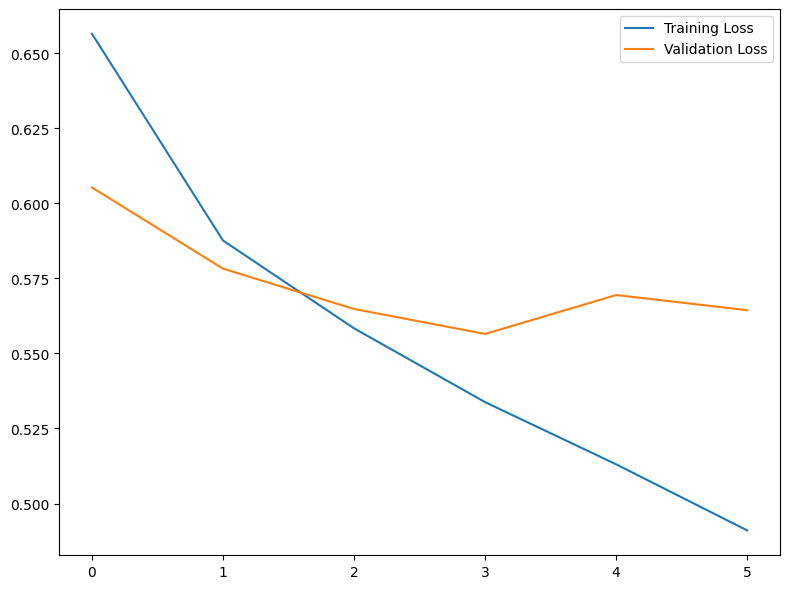

In [14]:
model_history = pd.DataFrame(callbacks.history)
model_history['epoch'] = callbacks.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["loss"], 
        label="Training Loss")
ax.plot(np.arange(0, num_epochs), model_history["val_loss"], 
        label="Validation Loss")
ax.legend()

plt.tight_layout()
plt.show()

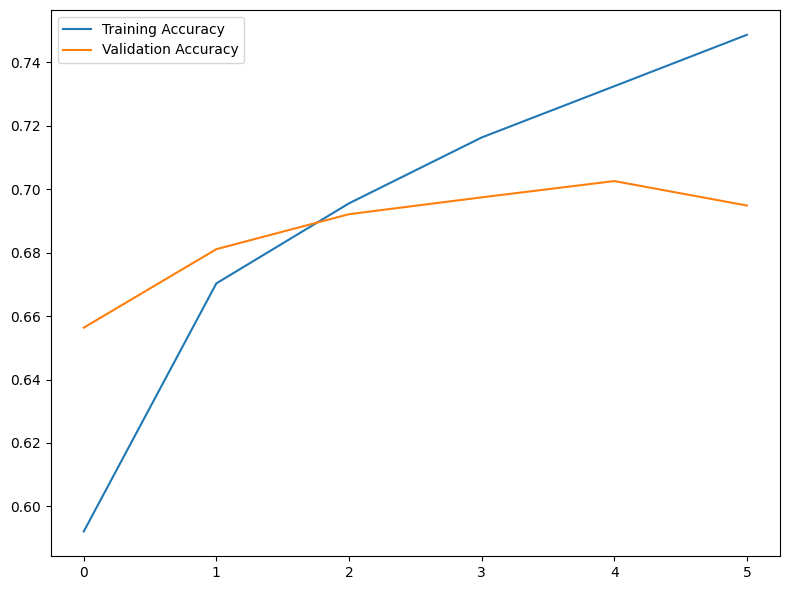

In [15]:
model_history = pd.DataFrame(callbacks.history)
model_history['epoch'] = callbacks.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()

plt.tight_layout()
plt.show()

# Fine Tuning

In [16]:
# Unfreeze bert layers.
model.trainable = True

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.000001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
callbacks_ft = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size = 32)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3250/3250 [==============================] - 515s 157ms/step - loss: 0.5083 - accuracy: 0.7357 - val_loss: 0.5352 - val_accuracy: 0.7241
Epoch 2/50
3250/3250 [==============================] - 508s 156ms/step - loss: 0.4808 - accuracy: 0.7569 - val_loss: 0.5215 - val_accuracy: 0.7343
Epoch 3/50
3250/3250 [==============================] - 510s 157ms/step - loss: 0.4614 - accuracy: 0.7685 - val_loss: 0.5250 - val_accuracy: 0.7408
Epoch 4/50
3250/3250 [==============================] - 508s 156ms/step - loss: 0.4431 - accuracy: 0.7811 - val_loss: 0.5085 - val_accuracy: 0.7450
Epoch 5/50
3250/3250 [==========================

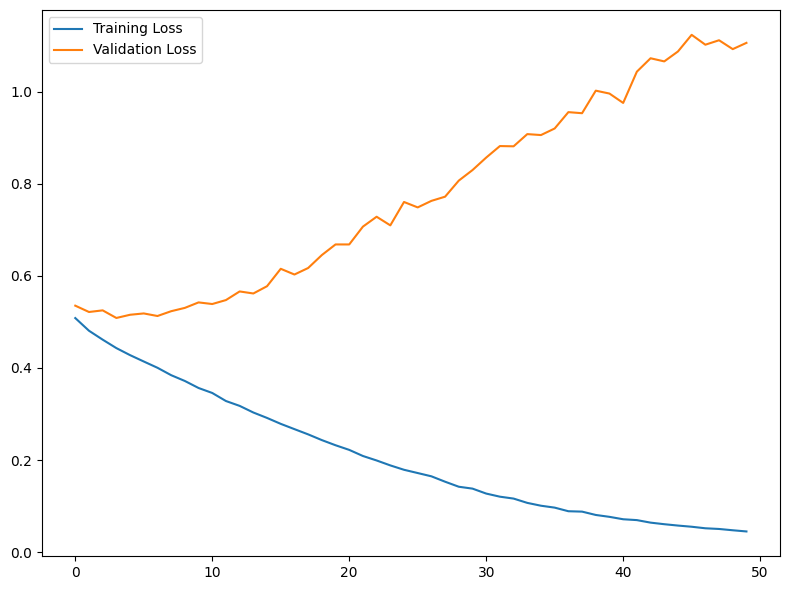

In [20]:
model_history = pd.DataFrame(callbacks_ft.history)
model_history['epoch'] = callbacks_ft.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["loss"], 
        label="Training Loss")
ax.plot(np.arange(0, num_epochs), model_history["val_loss"], 
        label="Validation Loss")
ax.legend()

plt.tight_layout()
plt.show()

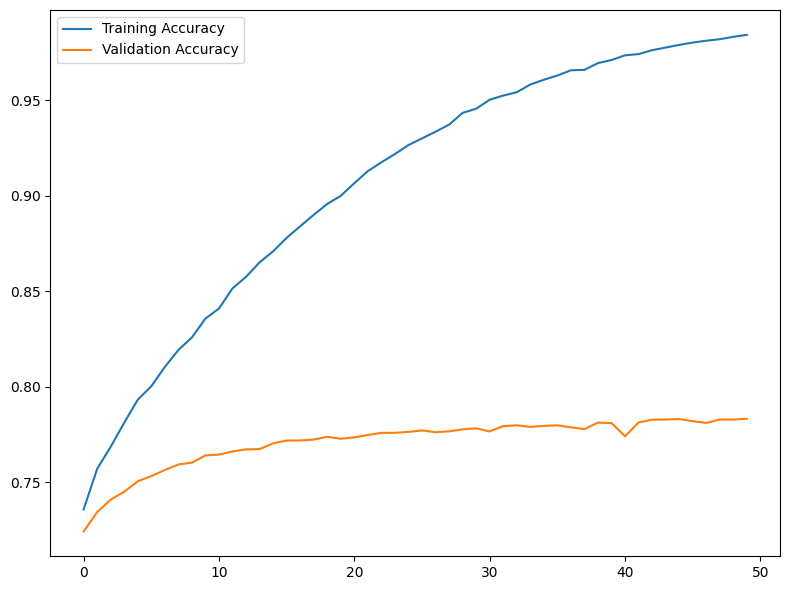

In [21]:
model_history = pd.DataFrame(callbacks_ft.history)
model_history['epoch'] = callbacks_ft.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()

plt.tight_layout()
plt.show()

In [26]:
callbacks_ft2 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size = 32)

Epoch 1/10
3250/3250 [==============================] - 560s 172ms/step - loss: 0.0417 - accuracy: 0.9855 - val_loss: 1.1558 - val_accuracy: 0.7832
Epoch 2/10
3250/3250 [==============================] - 633s 195ms/step - loss: 0.0404 - accuracy: 0.9857 - val_loss: 1.1629 - val_accuracy: 0.7832
Epoch 3/10
3250/3250 [==============================] - 521s 160ms/step - loss: 0.0390 - accuracy: 0.9864 - val_loss: 1.1956 - val_accuracy: 0.7864
Epoch 4/10
3250/3250 [==============================] - 518s 160ms/step - loss: 0.0373 - accuracy: 0.9868 - val_loss: 1.1879 - val_accuracy: 0.7847
Epoch 5/10
3250/3250 [==============================] - 518s 159ms/step - loss: 0.0355 - accuracy: 0.9872 - val_loss: 1.1890 - val_accuracy: 0.7818
Epoch 6/10
3250/3250 [==============================] - 511s 157ms/step - loss: 0.0353 - accuracy: 0.9875 - val_loss: 1.1499 - val_accuracy: 0.7824
Epoch 7/10
3250/3250 [==============================] - 506s 156ms/step - loss: 0.0322 - accuracy: 0.9886 - val_

In [27]:
callbacks_ft2 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size = 32)

Epoch 1/10
3250/3250 [==============================] - 518s 159ms/step - loss: 0.0288 - accuracy: 0.9899 - val_loss: 1.2567 - val_accuracy: 0.7855
Epoch 2/10
3250/3250 [==============================] - 599s 184ms/step - loss: 0.0265 - accuracy: 0.9910 - val_loss: 1.2840 - val_accuracy: 0.7857
Epoch 3/10
3250/3250 [==============================] - 592s 182ms/step - loss: 0.0262 - accuracy: 0.9909 - val_loss: 1.2840 - val_accuracy: 0.7857
Epoch 4/10
3250/3250 [==============================] - 513s 158ms/step - loss: 0.0247 - accuracy: 0.9914 - val_loss: 1.2601 - val_accuracy: 0.7852
Epoch 5/10
3250/3250 [==============================] - 512s 157ms/step - loss: 0.0244 - accuracy: 0.9918 - val_loss: 1.2989 - val_accuracy: 0.7874
Epoch 6/10
3250/3250 [==============================] - 504s 155ms/step - loss: 0.0232 - accuracy: 0.9923 - val_loss: 1.2749 - val_accuracy: 0.7872
Epoch 7/10
3250/3250 [==============================] - 503s 155ms/step - loss: 0.0211 - accuracy: 0.9927 - val_

In [22]:
model.save('../SavedModels/v1')

INFO:tensorflow:Assets written to: SavedModels/assets


INFO:tensorflow:Assets written to: SavedModels/assets


# Examples

In [23]:
x_examples = x_test[:100].tolist()
y_examples = y_test[:100].tolist()

In [24]:
examples_predictions = model.predict(x_examples)
examples_predictions[examples_predictions >= .5] = 1
examples_predictions[examples_predictions < .5] = 0

In [25]:
label_list = ["Not Watermarked", "Watermarked"]
for i in range(len(x_examples)):
    sentance = x_examples[i]
    true_label = y_examples[i]
    
    print("True label: " + label_list[true_label])
    print("Predicted label: " + label_list[int(examples_predictions[i][0])])
    print("Sentence: " + sentance)
    print()

True label: Watermarked
Predicted label: Watermarked
Sentence: gradually they emerged as women.

True label: Watermarked
Predicted label: Watermarked
Sentence: 17: 20 and when absalom' s servant came to the woman to the house, they said, where is ahimaaz and jonathan?

True label: Not Watermarked
Predicted label: Watermarked
Sentence: and now that at the proper time and place, after so long and wide a preliminary cruise, ahab,-- all other whaling waters swept--seemed to have chased his foe into an ocean - fold, to slay him the more securely there; now, that he found himself hard by the very latitude and longitude where his tormenting wound had been inflicted; now that a vessel had been spoken which on the very day preceding had actually encountered moby dick;-- and now that all his successive meetings with various ships contrastingly concurred to show the demoniac indifference with which the white whale tore his hunters, whether sinning or sinned against; now it was that there lurked a